<a href="https://colab.research.google.com/github/honestycitra/dl_hw_test/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inception Score Evaluation**

Source: https://github.com/DSC-UI-SRIN/Introduction-to-GAN/blob/master/3%20-%20GAN%20Evaluations/Inception_score.ipynb

# Introduction

The Inception Score or IS is an objective metric for evaluating the quality of generated images, specifically synthetic images output by generative adversarial network models. and proposed by [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper

In [1]:
import os
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Folder Configuration
from google.colab import drive
drive.mount('/content/drive')
ROOT = "/content/drive/My Drive/Colab Notebooks/DSC_UI_GAN/Batch1/W3/"
weight_dir = os.path.join(ROOT, 'weight')
# Make dir if no exist
if not os.path.exists(weight_dir):
    os.makedirs(weight_dir)

Mounted at /content/drive


# Load DCGAN Model

DCGAN Model is based on [pytorch examples repo](https://github.com/pytorch/examples/tree/main/dcgan) and weight from github [csinva/gan-pretrained-pytorch](https://github.com/csinva/gan-vae-pretrained-pytorch)

## **Downlaod Model**

In [2]:
import urllib.request
url = "https://github.com/DSC-UI-SRIN/Introduction-to-GAN/raw/master/3%20-%20GAN%20Evaluations/weight/{file}"
netD_file = "netD_epoch_199.pth"
netG_file = "netG_epoch_199.pth"

# Check file D and G, download if doesn't exist
if not os.path.exists(os.path.join(weight_dir, netD_file)):
    urllib.request.urlretrieve(url.format(file=netD_file), os.path.join(weight_dir, netD_file))
if not os.path.exists(os.path.join(weight_dir, netG_file)):
    urllib.request.urlretrieve(url.format(file=netG_file), os.path.join(weight_dir, netG_file))

## **Init Model**

In [3]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np
%load_ext autoreload
%autoreload 2

class Generator(nn.Module):
    def __init__(self, ngpu, nc=3, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

## **Load Model**

In [4]:
num_gpu = 1 if torch.cuda.is_available() else 0

D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

# load weights
D.load_state_dict(torch.load(os.path.join(weight_dir, netD_file)))
G.load_state_dict(torch.load(os.path.join(weight_dir, netG_file)))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

RuntimeError: ignored

## **Generate Images**

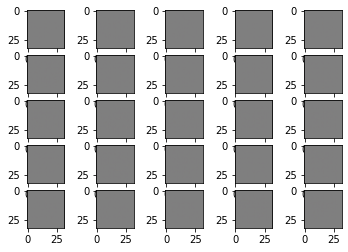

In [5]:
# Generate
batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)


# z = torch.randn(batch_size, latent_size).cuda()
# z = Variable(z)
# fake_images = G(z)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 3, 32, 32)
fake_images_np = fake_images_np.transpose((0, 2, 3, 1))
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i] * 0.5 + 0.5, interpolation='bilinear')
plt.show()

# **Inception Score Function**

In [6]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

# **Result**

In [7]:
# Generate
batch_size = 32
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()

fake_images = G(fixed_noise)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 3, 32, 32)

In [8]:
inception_score(fake_images_np, cuda=True, batch_size=16, resize=True, splits=1)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

RuntimeError: ignored